# Dreambooth Training with Hugging Face Diffusers

#### Step 1: Clone Diffusers GitHub Repository


In [1]:
import os

if not os.path.exists('diffusers'):
    !git clone https://github.com/huggingface/diffusers

Cloning into 'diffusers'...
remote: Enumerating objects: 62761, done.
remote: Counting objects: 100% (12853/12853), done.
remote: Compressing objects: 100% (959/959), done.
remote: Total 62761 (delta 12512), reused 11922 (delta 11886), pack-reused 49908
Receiving objects: 100% (62761/62761), 42.53 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (46195/46195), done.


### Step 2: Install Diffusers and Additional Dependencies

In [2]:
!pip install transformers==4.30.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.0
    Uninstalling transformers-4.41.0:
      Successfully uninstalled transformers-4.41.0


In [3]:
wwew

NameError: name 'wwew' is not defined

In [4]:
%cd diffusers
!pip install -q .

/content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
%cd examples/dreambooth/
!pip install -q -r requirements.txt

/content/diffusers/examples/dreambooth
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 62.5 MB/s eta 0:00:00


In [6]:
seed = 42

### Step 3 Setup Accelerate with Basic Configuration

In [7]:
from accelerate.utils import write_basic_config

write_basic_config()

PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

### Step 4 Download Data

In [8]:
import os
import requests
import zipfile

def download_and_unzip(url, save_path):
    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        with zipfile.ZipFile(save_path) as z:
            z.extractall(os.path.split(save_path)[0]) # Unzip where downloaded.
            print("Done")
    except Exception as e:
        print(f"Error: {e}")

URL = r"https://github.com/dsabarinathan/diffusion_sample/blob/main/Dreambooth/anya.zip?raw=true"

dataset_name = "anya"
dataset_zip_path = os.path.join(os.getcwd(), f"{dataset_name}.zip")
dataset_path = os.path.join(os.getcwd(), dataset_name)

# Download if dataset does not exist.
if not os.path.exists(dataset_path):
    download_and_unzip(URL, dataset_zip_path)


### Step 5 Training the model with custom dataset

In [9]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="anya" \
  --output_dir="outputs" \
  --instance_prompt="a photo of anya anime character" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=500 \
  --mixed_precision="fp16" \
  --checkpointing_steps=50000

2024-05-23 13:38:17.701138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 13:38:17.701187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 13:38:17.703114: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 13:38:18.749721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
05/23/2024 13:38:19 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1

## Step 6 Inference

In [10]:
from diffusers import StableDiffusionPipeline

import torch

In [11]:
seed = 42

In [12]:
pipe = StableDiffusionPipeline.from_pretrained(
    'outputs',
    torch_dtype=torch.float16,
).to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

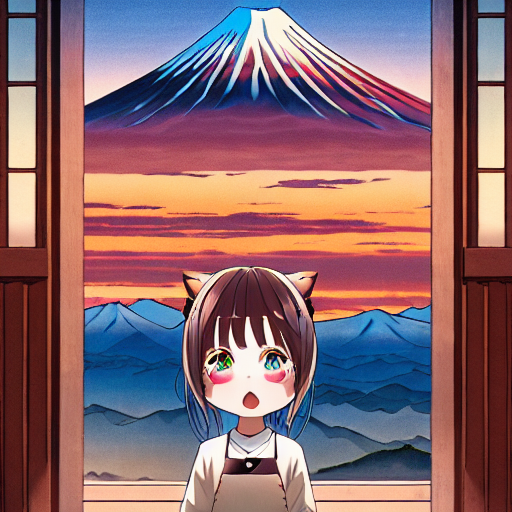

In [13]:
#prompt = "a photo of aks anya anime character, in front Mount Fuji at sunset, highly detailed, 4k"
prompt = "a photo of anya anime character,in front Mount Fuji at sunset, highly detailed, 4k"

image = pipe(prompt, num_inference_steps=150, generator=torch.manual_seed(seed)).images[0]

image

  0%|          | 0/165 [00:00<?, ?it/s]

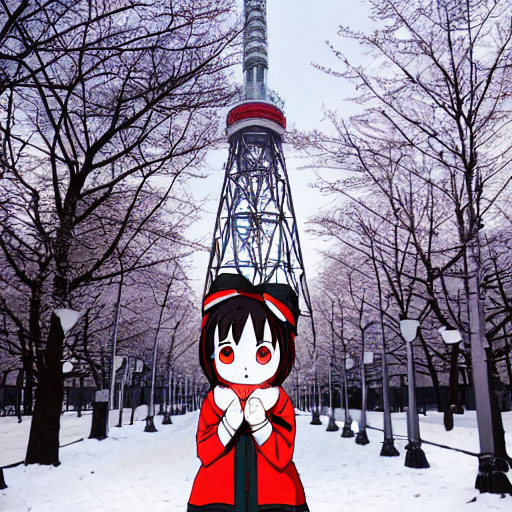

In [17]:
prompt = "a photo of anya anime character,in front of Sapporo Tower ,in winter highly detailed"
image = pipe(prompt, num_inference_steps=165, generator=torch.manual_seed(seed)).images[0]

image

  0%|          | 0/150 [00:00<?, ?it/s]

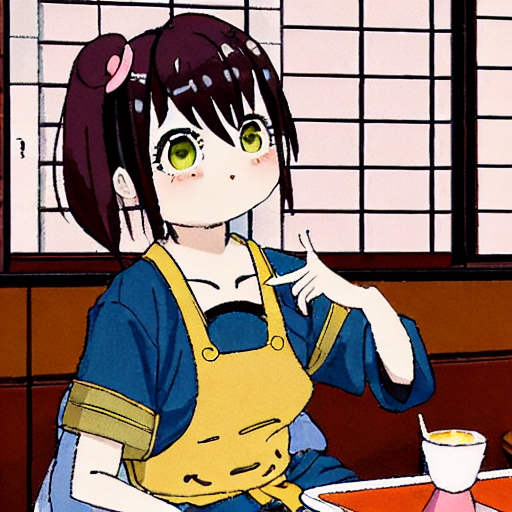

In [18]:
prompt = "a photo of anya anime character, sitting on a couch, in a sushi restaurant in Japan"
image = pipe(prompt, num_inference_steps=150, generator=torch.manual_seed(seed)).images[0]

image

  0%|          | 0/170 [00:00<?, ?it/s]

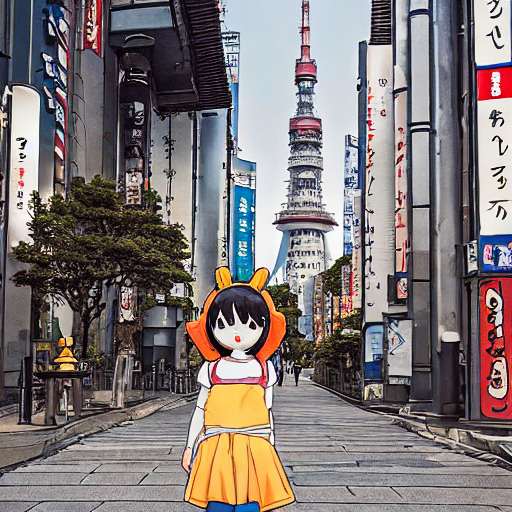

In [33]:
prompt = "a photo of anya anime character, in front of the Tokyo Tower,highly detailed"
image = pipe(prompt, num_inference_steps=170, generator=torch.manual_seed(seed)).images[0]

image

  0%|          | 0/170 [00:00<?, ?it/s]

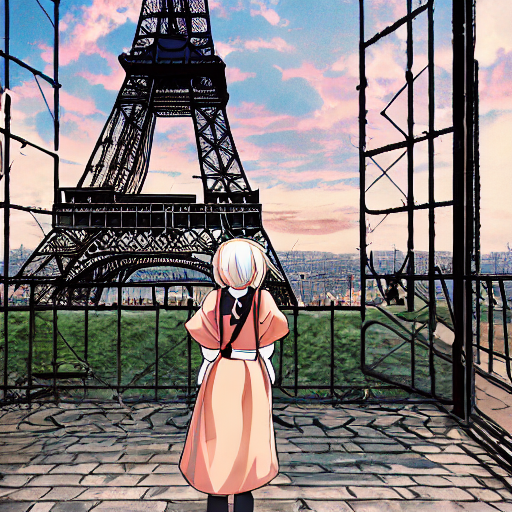

In [27]:
prompt = "a photo of anya anime character, in front of the eiffel tower"
image = pipe(prompt, num_inference_steps=170, generator=torch.manual_seed(seed)).images[0]

image

  0%|          | 0/150 [00:00<?, ?it/s]

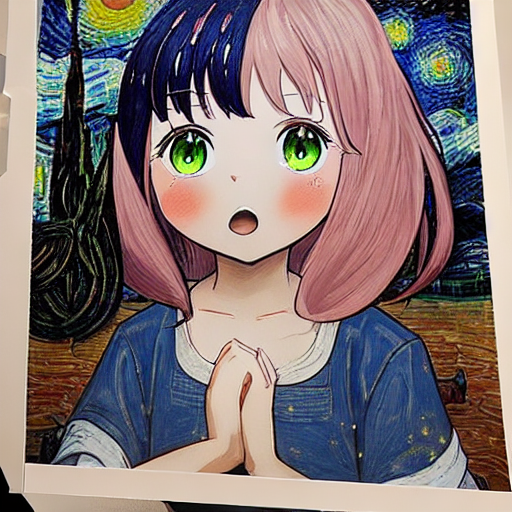

In [21]:
prompt = "a photo of anya anime character with the starry night painting in the background"
image = pipe(
    prompt,
    num_inference_steps=150,
    generator=torch.manual_seed(seed)
).images[0]

image

  0%|          | 0/170 [00:00<?, ?it/s]

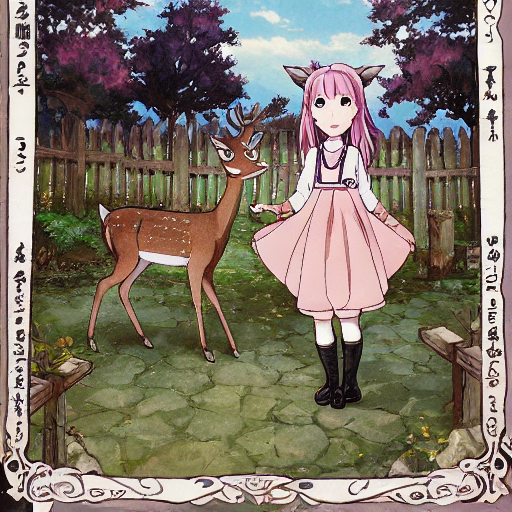

In [29]:
prompt = "a photo of anya anime character with the nara deer, in the garden"
image = pipe(prompt, num_inference_steps=170, generator=torch.manual_seed(seed)).images[0]

image

  0%|          | 0/170 [00:00<?, ?it/s]

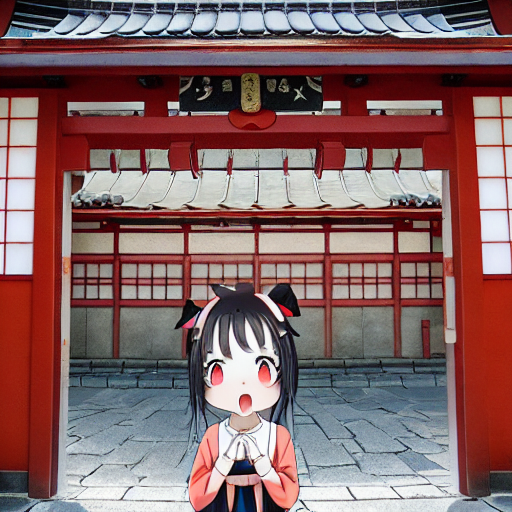

In [32]:
prompt = "a photo of anya anime character ,infront of the japan shrine entrance gate,4k"
image = pipe(prompt, num_inference_steps=170, generator=torch.manual_seed(seed)).images[0]

image